In [1]:
from IPython.core.display import Markdown, display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from collections import defaultdict
import traceback
import numpy as np
import scipy.stats as ss
import random
import copy
import yaml
import itertools
import sys
import os
import subprocess
from os import path
import pickle
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
np.set_printoptions(edgeitems=30, linewidth=1000)

from sklearn.linear_model import LinearRegression, TheilSenRegressor, RANSACRegressor, HuberRegressor, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline

def printmd(*args):
    display(Markdown(' '.join(map(str, args))))

def print_warn(*args):
    printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{' '.join(map(str, args))}</font></code>")

In [2]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning/*" -s

In [3]:
# !ros2 run local_planning_performance_modelling compute_metrics -r "~/ds/performance_modelling/output/test_local_planning_gen_circles/*" -s

In [4]:
local_planner_color = {'dwb': 'blue', 'rpp': 'orange', 'teb': 'green'}
robot_model_color = {'hunter': 'cyan', 'turtle': 'green'}
pd.options.display.width = 500
pd.options.display.max_rows = 0
pd.options.display.float_format = '{:,.3f}'.format
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['lines.linewidth'] = 2
# plt.rcParams['lines.markersize'] = 3
# plt.rcParams['lines.marker'] = 'o'

# fg_color = 'white'
# plt.rcParams['grid.color'] = 'gray'
# plt.rcParams['text.color'] = fg_color
# plt.rcParams['ytick.color'] = fg_color
# plt.rcParams['xtick.color'] = fg_color
# plt.rcParams['axes.labelcolor'] = fg_color
# plt.rcParams['axes.edgecolor'] = fg_color

# bg_color = "#323a48"
# plt.rcParams['figure.facecolor'] = bg_color
# plt.rcParams['axes.facecolor'] = bg_color
# plt.rcParams['legend.facecolor'] = bg_color

In [5]:
df = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_info_file:
    results_info = yaml.safe_load(results_info_file)

# df_real = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning/results_info.yaml")) as results_real_info_file:
#     results_real_info = yaml.safe_load(results_real_info_file)
# df_real = df_real[(df_real.amcl_alpha_factor.notna()) & (df_real.robot_model=='turtlebot3_waffle_performance_modelling')]
# 
# df_gen = pd.read_csv(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results.csv"))
# with open(path.expanduser("~/ds/performance_modelling/output/test_local_planning_gen_circles/results_info.yaml")) as results_gen_info_file:
#     results_gen_info = yaml.safe_load(results_gen_info_file)

# df = df_gen.append(df_real, sort=True)

df.rename(inplace=True, columns={
    'collisionless_localization_update_absolute_translation_error_mean': 'absolute_translation_error',
    'collisionless_localization_update_absolute_rotation_error_mean': 'absolute_rotation_error',
    'collisionless_localization_update_normalized_relative_translation_error_mean': 'normalized_relative_translation_error',
    'collisionless_localization_update_normalized_relative_rotation_error_mean': 'normalized_relative_rotation_error',
    'localization_update_rate_mean': 'localization_update_rate',
})

# results_info = results_gen_info
# results_info['run_parameter_names'] += [i for i in results_real_info['run_parameter_names'] if i not in results_info['run_parameter_names']]

# TEMP: only consider real localization
# df = df[df.localization_node != 'localization_generator']
# df = df[(df.amcl_alpha_factor == 1.0) | (df.amcl_alpha_factor == 0.0)]

df.fixed_rpp = df.fixed_rpp.fillna(False)
df.loc[(df.fixed_rpp == False) & (df.local_planner_node == 'rpp'), 'local_planner_node'] = 'rpp_bad'
df = df[df.local_planner_node != 'rpp_bad'].copy()

df.run_duplicate_index = df.run_duplicate_index.fillna(0)

# df = df[df.amcl_alpha_factor.notna()]

# turn odometry_error into beta_1..4
results_info['run_parameter_names'] += ['beta_1', 'beta_2', 'beta_3', 'beta_4']
results_info['run_parameter_names'].remove('odometry_error')
for i in range(0, 4):
    df[f'beta_{i+1}'] = df['odometry_error'].apply(lambda x: eval(x)[i])
del df['odometry_error']

df.loc[df.robot_model == 'turtlebot3_waffle_performance_modelling', 'robot_model'] = 'turtle'
df.loc[df.robot_model == 'hunter2', 'robot_model'] = 'hunter'

run_parameters = [c for c in list(df.columns) if c in results_info['run_parameter_names']]
metrics_versions = [c for c in list(df.columns) if '_version' in c]
everything_else = ['run_id', 'session_id', 'run_number']
metrics = [c for c in df.columns if c not in metrics_versions + run_parameters + everything_else]
metrics_and_versions = [c for c in list(df.columns) if '_version' in c or c in metrics]

cpu_time_metrics = [c for c in metrics if 'cpu_time' in c]
max_memory_metrics = [c for c in metrics if 'max_memory' in c]

# add useful parameters
df['session_id'] =  df['run_id'].apply(lambda x:  x.split('_')[1]+'_'+x.split('_')[2]+'_'+x.split('_')[3])
df['run_number'] =  df['run_id'].apply(lambda x:  int(x.split('_')[5]))
df[max_memory_metrics] = df[max_memory_metrics]/1024**2
df.max_steering_angle_deg = df.max_steering_angle_deg.fillna(90)

# add metrics from existing ones
df['average_velocity'] = df['trajectory_length'] / df['execution_time']
df['collisionless_success_rate'] = df['success_rate'] & (1 - df['collision_rate'])
metrics += ['average_velocity', 'collisionless_success_rate']
metrics_and_versions += ['average_velocity', 'collisionless_success_rate']

# add aggregated data
min_trajectory_length_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_trajectory_length_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_trajectory_length'] = group_df.trajectory_length.min()
df['norm_trajectory_length'] = df.trajectory_length / df.min_trajectory_length
metrics += ['norm_trajectory_length']
metrics_and_versions += ['norm_trajectory_length']

min_execution_time_group_df = df.groupby(["environment_name", "run_index", "collisionless_success_rate"])
for (environment_name, run_index, collisionless_success_rate), group_df in min_execution_time_group_df:
    df.loc[(df.environment_name == environment_name) & (df.run_index == run_index) & (collisionless_success_rate), 'min_execution_time'] = group_df.execution_time.min()
df['norm_execution_time'] = df.execution_time / df.min_execution_time
metrics += ['norm_execution_time']
metrics_and_versions += ['norm_execution_time']

if False:
# if True:
    printmd("## Number of Runs")
    printmd(f"    {len(df.run_id.unique())}")

    printmd("## Run Parameters")
    for name in [run_parameter_name for run_parameter_name in run_parameters if 'localization_generator_' not in run_parameter_name]:
        values = list(df[name].unique())
        printmd(f"    {name:<70}", sorted(values))

    printmd("## Metrics")
    for name in metrics_and_versions:
        if name in metrics_versions:
            if len(df[name].unique()) == 1:
                printmd(f"    {name:<70} {sorted(df[name].unique())}")
            else:
                printmd(f"<code><font style='background-color:yellow;font-family:monospace'>{name:<70}{sorted(df[name].unique())} </font></code> ⚠️")
        else:
            printmd(f"    {name:<70} min: {df[name].min(skipna=True):10.4g} {'avg':>15}: {df[name].mean(skipna=True):10.4g} {'max':>15}: {df[name].max(skipna=True):10.4g} {'nan':>15}: {sum(df[name].isna()):10.4g}")

In [6]:
# # dataset splits based on run_index
# ri = sorted(df.run_index.unique())
# random.Random(0).shuffle(ri)
# l = len(ri)
# split_localization, split_local_planner, split_ground_truth = ri[0:int(l/3)], ri[int(l/3):int(2*l/3)], ri[int(2*l/3):]
# len(split_localization), len(split_local_planner), len(split_ground_truth)

In [7]:
# dataset splits based on run_duplicate_index
split_localization, split_local_planner, split_ground_truth = [0], [1], [2]

In [8]:
# discretize features
bin_widths_dict = {
    'amcl_alpha_factor': (None, None),
    'beta_1': (None, None),
    'absolute_translation_error': (0.0, 0.06),
    'absolute_rotation_error': (0.0, 0.03),
    'normalized_relative_translation_error': (0.0, 0.03),
    'normalized_relative_rotation_error': (0.0, 0.015),
    'collisionless_success_rate': (-0.5, 1),
    'collision_rate': (-0.5, 1),
    'norm_trajectory_length': (1.0, 0.015),
    'norm_execution_time': (1.0, 0.015),
    'average_translation_velocity': (0.0, 0.015),
    'average_velocity_atan': (0.0, 0.15),
}
# bin_widths_dict = {
#     'amcl_alpha_factor': (None, None),
#     'beta_1': (None, None),
#     'absolute_translation_error': (0.0, 0.03),
#     'absolute_rotation_error': (0.0, 0.003),
#     'normalized_relative_translation_error': (0.0, 0.015),
#     'normalized_relative_rotation_error': (0.0, 0.015),
#     'collisionless_success_rate': (-0.5, 1),
#     'collision_rate': (-0.5, 1),
#     'norm_trajectory_length': (1.0, 0.015),
#     'norm_execution_time': (1.0, 0.015),
#     'average_translation_velocity': (0.0, 0.015),
#     'average_velocity_atan': (0.0, 0.15),
# }

bins_dict = dict()
for feature_name, (bin_min, bin_width) in bin_widths_dict.items():
    if bin_width is not None:
        bins = np.arange(bin_min, df[feature_name].max() + bin_width, bin_width)
        bins_dict[feature_name] = bins[:-1]
        df[f'{feature_name}_d'] = pd.cut(df[feature_name], bins, right=False, labels=bins[:-1]).astype('float')
    else:
        df[f'{feature_name}_d'] = df[feature_name]
        bins_dict[feature_name] = sorted(df[feature_name].unique())


In [9]:

local_planner_performance_all = [
    'collisionless_success_rate',
    'collision_rate',
]
local_planner_performance_success = [
    'norm_trajectory_length',
    'norm_execution_time',
]



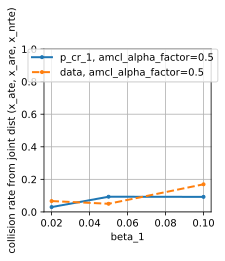

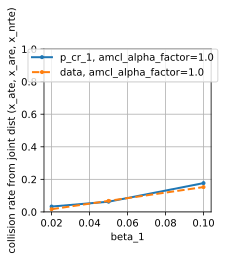

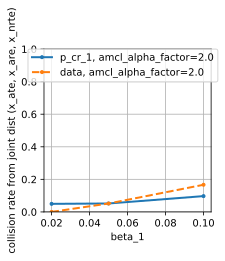

In [10]:
def compute_joint_cr(amcl_alpha_factor, beta_1, smoothing_value):
    
    localization_performance = [
        'absolute_translation_error',
        'absolute_rotation_error',
        'normalized_relative_translation_error',
    #     'normalized_relative_rotation_error',
    ]
    
    d_all = df[
        (df.max_steering_angle_deg == 90.) &
        (df.robot_model == 'turtle') &
        (df.global_planner_node == 'navfn') &
        (df.localization_node == 'amcl')  &
        (df.local_planner_node == 'teb') &
        (df.amcl_alpha_factor == amcl_alpha_factor) &
        (df.beta_1 == beta_1)].copy()
#     d_success = df[
#         (df.collisionless_success_rate == 1) &
#         (df.max_steering_angle_deg == 90.) &
#         (df.robot_model == 'turtle') &
#         (df.global_planner_node == 'navfn') &
#         (df.localization_node == 'amcl') &
#         (df.local_planner_node == 'teb') &
#         (df.amcl_alpha_factor == amcl_alpha_factor) &
#         (df.beta_1 == beta_1)].copy()
#     print(d_all)
    d_localization = d_all[d_all.run_duplicate_index.isin(split_localization)]
    d_local_planner_all = d_all[d_all.run_duplicate_index.isin(split_local_planner)]
#     d_local_planner_success = d_success[d_success.run_index.isin(split_local_planner)]
    d_gt_all = d_all[d_all.run_duplicate_index.isin(split_ground_truth)]
#     d_gt_success = d_success[d_success.run_index.isin(split_ground_truth)]

    dl = d_localization
    joint_count = dl.groupby(localization_performance)[localization_performance].count()
    itertools.product()

    loc_bins = [bins_dict[x] for x in bins_dict.keys() if x in localization_performance]
    loc_space_comb = list(itertools.product(*loc_bins))
    localization_performance_len = tuple(map(len, loc_bins))
#     print("localization_performance_len", localization_performance_len)
    p = np.zeros(localization_performance_len)
    count = np.zeros(localization_performance_len)
    for (i, j, k), (x_ate, x_are, x_nrte) in zip(np.ndindex(*localization_performance_len), loc_space_comb):
#         print(f"ate_i={i}, are_i={j}, x_ate={x_ate}, x_are={x_are}, x_nrte={x_nrte}, ")
#         print(dl[(dl.absolute_translation_error_d == x_ate) & (dl.absolute_rotation_error_d == x_are) & (dl.normalized_relative_translation_error_d == x_nrte)][localization_performance])
        count[i, j, k] = dl[(dl.absolute_translation_error_d == x_ate) & (dl.absolute_rotation_error_d == x_are) & (dl.normalized_relative_translation_error_d == x_nrte)][localization_performance[0]].count()
#         print(count[i, j, k])

    p = (count / count.sum()) + np.ones(localization_performance_len) * smoothing_value
#     print(p)
    p = p / p.sum()
#     print(p)

    # print(localization_performance)
    # print(localization_performance_len)

    # print("p")
    # print(p)
    # print("ate marginal", p.sum(axis=1))
    # print("are marginal", p.sum(axis=0))

    dlp = d_local_planner_all

    p_cr_0 = 0.0
    for (i, j, k), (x_ate, x_are, x_nrte) in zip(np.ndindex(*localization_performance_len), loc_space_comb):
        count_ij = dlp[(dlp.collision_rate_d == -0.5) & (dlp.absolute_translation_error_d == x_ate) & (dlp.absolute_rotation_error_d == x_are) & (dlp.normalized_relative_translation_error_d == x_nrte)]['collision_rate_d'].count()
        total_ij = dlp[(dlp.absolute_translation_error_d == x_ate) & (dlp.absolute_rotation_error_d == x_are) & (dlp.normalized_relative_translation_error_d == x_nrte)]['collision_rate_d'].count()
        p_cr_0 += p[i, j, k] * (count_ij / total_ij) if total_ij > 0 else 0
    
    p_cr_1 = 0.0
    for (i, j, k), (x_ate, x_are, x_nrte) in zip(np.ndindex(*localization_performance_len), loc_space_comb):
        count_ij = dlp[(dlp.collision_rate_d == 0.5) & (dlp.absolute_translation_error_d == x_ate) & (dlp.absolute_rotation_error_d == x_are) & (dlp.normalized_relative_translation_error_d == x_nrte)]['collision_rate_d'].count()
        total_ij = dlp[(dlp.absolute_translation_error_d == x_ate) & (dlp.absolute_rotation_error_d == x_are) & (dlp.normalized_relative_translation_error_d == x_nrte)]['collision_rate_d'].count()
        p_cr_1 += p[i, j, k] * (count_ij / total_ij) if total_ij > 0 else 0
    
#     print("p_cr_0 + p_cr_1", p_cr_0 + p_cr_1)
    p_cr_1 = p_cr_1 / (p_cr_0 + p_cr_1)
    
    p_cr_1_gt = d_gt_all['collision_rate'].mean()
    
    return p_cr_1, p_cr_1_gt

# amcl_alpha_factor_values = [1.0]
amcl_alpha_factor_values = [0.5, 1.0, 2.0]
beta_1_values = [0.02, 0.05, 0.1]
# for smoothing_value in np.linspace(0.0001, 0.01, 100):
for smoothing_value in [0.0]:
    for amcl_alpha_factor in amcl_alpha_factor_values:
        fig = plt.figure()
        beta_1_y_p_cr_1 = list()
        beta_1_y_data = list()
        for beta_1 in beta_1_values:
            p_cr_1, p_cr_1_gt = compute_joint_cr(amcl_alpha_factor, beta_1, smoothing_value=smoothing_value)
            beta_1_y_p_cr_1.append(p_cr_1)
            beta_1_y_data.append(p_cr_1_gt)
        plt.plot(beta_1_values, beta_1_y_p_cr_1, '.-', label=f"p_cr_1, amcl_alpha_factor={amcl_alpha_factor}")
        plt.plot(beta_1_values, beta_1_y_data, '.--', label=f"data, amcl_alpha_factor={amcl_alpha_factor}")

        plt.grid()
        plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.xlabel("beta_1")
        plt.ylabel(f"{'collision_rate'.replace('_', ' ')} from joint dist (x_ate, x_are, x_nrte)")
        plt.ylim([0, 1])
        fig.set_size_inches([3, 3])
#         plt.savefig(f"plots/smoothing/ate_are_nrte___amcl_{int(amcl_alpha_factor*10)}_smoothing_{int(smoothing_value*1000000)}.png")
#         plt.close()
        plt.show()


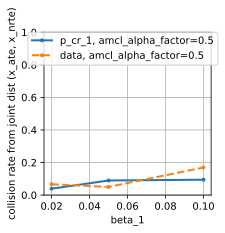

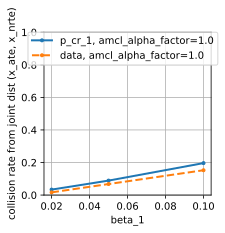

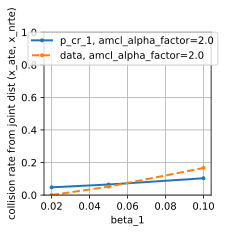

In [11]:
def compute_joint_cr(amcl_alpha_factor, beta_1, smoothing_value):
    
    localization_performance = [
        'absolute_translation_error',
#         'absolute_rotation_error',
        'normalized_relative_translation_error',
    #     'normalized_relative_rotation_error',
    ]
    d_all = df[
        (df.max_steering_angle_deg == 90.) &
        (df.robot_model == 'turtle') &
        (df.global_planner_node == 'navfn') &
        (df.localization_node == 'amcl')  &
        (df.local_planner_node == 'teb') &
        (df.amcl_alpha_factor == amcl_alpha_factor) &
        (df.beta_1 == beta_1)].copy()
#     d_success = df[
#         (df.collisionless_success_rate == 1) &
#         (df.max_steering_angle_deg == 90.) &
#         (df.robot_model == 'turtle') &
#         (df.global_planner_node == 'navfn') &
#         (df.localization_node == 'amcl') &
#         (df.local_planner_node == 'teb') &
#         (df.amcl_alpha_factor == amcl_alpha_factor) &
#         (df.beta_1 == beta_1)].copy()

    d_localization = d_all[d_all.run_duplicate_index.isin(split_localization)]
    d_local_planner_all = d_all[d_all.run_duplicate_index.isin(split_local_planner)]
#     d_local_planner_success = d_success[d_success.run_index.isin(split_local_planner)]
    d_gt_all = d_all[d_all.run_duplicate_index.isin(split_ground_truth)]
#     d_gt_success = d_success[d_success.run_index.isin(split_ground_truth)]

    dl = d_localization
    joint_count = dl.groupby(localization_performance)[localization_performance].count()
    itertools.product()

    loc_bins = [bins_dict[x] for x in bins_dict.keys() if x in localization_performance]
    loc_space_comb = list(itertools.product(*loc_bins))
    localization_performance_len = tuple(map(len, loc_bins))
#     print("localization_performance_len", localization_performance_len)
    p = np.zeros(localization_performance_len)
    count = np.zeros(localization_performance_len)
    for (i, j), (x_ate, x_nrte) in zip(np.ndindex(*localization_performance_len), loc_space_comb):
#         print(f"ate_i={i}, are_i={j}, x_ate={x_ate}, x_are={x_are}, x_nrte={x_nrte}, ")
#         print(dl[(dl.absolute_translation_error_d == x_ate) & (dl.absolute_rotation_error_d == x_are) & (dl.normalized_relative_translation_error_d == x_nrte)][localization_performance])
        count[i, j] = dl[(dl.absolute_translation_error_d == x_ate) & (dl.normalized_relative_translation_error_d == x_nrte)][localization_performance[0]].count()
    #     print(count[i, j])

    p = (count / count.sum()) + np.ones(localization_performance_len) * smoothing_value
#     print(p)
    p = p / p.sum()
#     print(p)

    # print(localization_performance)
    # print(localization_performance_len)

    # print("p")
    # print(p)
    # print("ate marginal", p.sum(axis=1))
    # print("are marginal", p.sum(axis=0))

    dlp = d_local_planner_all

    p_cr_0 = 0.0
    for (i, j), (x_ate, x_nrte) in zip(np.ndindex(*localization_performance_len), loc_space_comb):
        count_ij = dlp[(dlp.collision_rate_d == -0.5) & (dlp.absolute_translation_error_d == x_ate) & (dlp.normalized_relative_translation_error_d == x_nrte)]['collision_rate_d'].count()
        total_ij = dlp[(dlp.absolute_translation_error_d == x_ate) & (dlp.normalized_relative_translation_error_d == x_nrte)]['collision_rate_d'].count()
        p_cr_0 += p[i, j] * (count_ij / total_ij) if total_ij > 0 else 0
    
    p_cr_1 = 0.0
    for (i, j), (x_ate, x_nrte) in zip(np.ndindex(*localization_performance_len), loc_space_comb):
        count_ij = dlp[(dlp.collision_rate_d == 0.5) & (dlp.absolute_translation_error_d == x_ate) & (dlp.normalized_relative_translation_error_d == x_nrte)]['collision_rate_d'].count()
        total_ij = dlp[(dlp.absolute_translation_error_d == x_ate) & (dlp.normalized_relative_translation_error_d == x_nrte)]['collision_rate_d'].count()
        p_cr_1 += p[i, j] * (count_ij / total_ij) if total_ij > 0 else 0
    
#     print("p_cr_0 + p_cr_1", p_cr_0 + p_cr_1)
    p_cr_1 = p_cr_1 / (p_cr_0 + p_cr_1)
    
    p_cr_1_gt = d_gt_all['collision_rate'].mean()
    
    return p_cr_1, p_cr_1_gt

# amcl_alpha_factor_values = [1.0]
amcl_alpha_factor_values = [0.5, 1.0, 2.0]
beta_1_values = [0.02, 0.05, 0.1]
# for smoothing_value in np.linspace(0.00001, 0.001, 100):
for smoothing_value in [0.0]:
    for amcl_alpha_factor in amcl_alpha_factor_values:
        fig = plt.figure()
        beta_1_y_p_cr_1 = list()
        beta_1_y_data = list()
        for beta_1 in beta_1_values:
            p_cr_1, p_cr_1_gt = compute_joint_cr(amcl_alpha_factor, beta_1, smoothing_value=smoothing_value)
            beta_1_y_p_cr_1.append(p_cr_1)
            beta_1_y_data.append(p_cr_1_gt)
        plt.plot(beta_1_values, beta_1_y_p_cr_1, '.-', label=f"p_cr_1, amcl_alpha_factor={amcl_alpha_factor}")
        plt.plot(beta_1_values, beta_1_y_data, '.--', label=f"data, amcl_alpha_factor={amcl_alpha_factor}")

        plt.grid()
        plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
        plt.xlabel("beta_1")
        plt.ylabel(f"{'collision_rate'.replace('_', ' ')} from joint dist (x_ate, x_nrte)")
        plt.ylim([0, 1])
        fig.set_size_inches([3, 3])
#         plt.savefig(f"plots/smoothing/ate_nrte___amcl_{int(amcl_alpha_factor*10)}_smoothing_{int(smoothing_value*1000000)}.png")
#         plt.close()
        plt.show()
